In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import VGG16
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np


In [ ]:
dataset_name = "imagenette"
full_dataset, info = tfds.load(dataset_name, with_info=True, split="train", as_supervised=True)

print(info)  # Check classes, number of images, etc.

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/full-size-v2/incomplete.638VNS_1.0.0/imagenette-train.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/full-size-v2/incomplete.638VNS_1.0.0/imagenette-validation.tfre…

Dataset imagenette downloaded and prepared to /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='imagenette',
    full_name='imagenette/full-size-v2/1.0.0',
    description="""
    Imagenette is a subset of 10 easily classified classes from the Imagenet
    dataset. It was originally prepared by Jeremy Howard of FastAI. The objective
    behind putting together a small version of the Imagenet dataset was mainly
    because running new ideas/algorithms/experiments on the whole Imagenet take a
    lot of time.
    
    This version of the dataset allows researchers/practitioners to quickly try out
    ideas and share with others. The dataset comes in three variants:
    
    *   Full size
    *   320 px
    *   160 px
    
    Note: The v2 config correspond to the new 70/30 train/valid split (released in
    Dec 6 2019).
    """,
    config_description="""
    full-size variant.
    """,
    homepage='https://g

In [ ]:
num_classes = info.features['label'].num_classes
print("Number of classes:", num_classes)


Number of classes: 10


In [ ]:
class_names = info.features['label'].names
print("Classes:", class_names)


Classes: ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


In [ ]:
#Normalizing image
IMG_SIZE = 224 #128*128 ma resize
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image=image/255.0
    return image, label



In [ ]:
full_dataset = full_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)


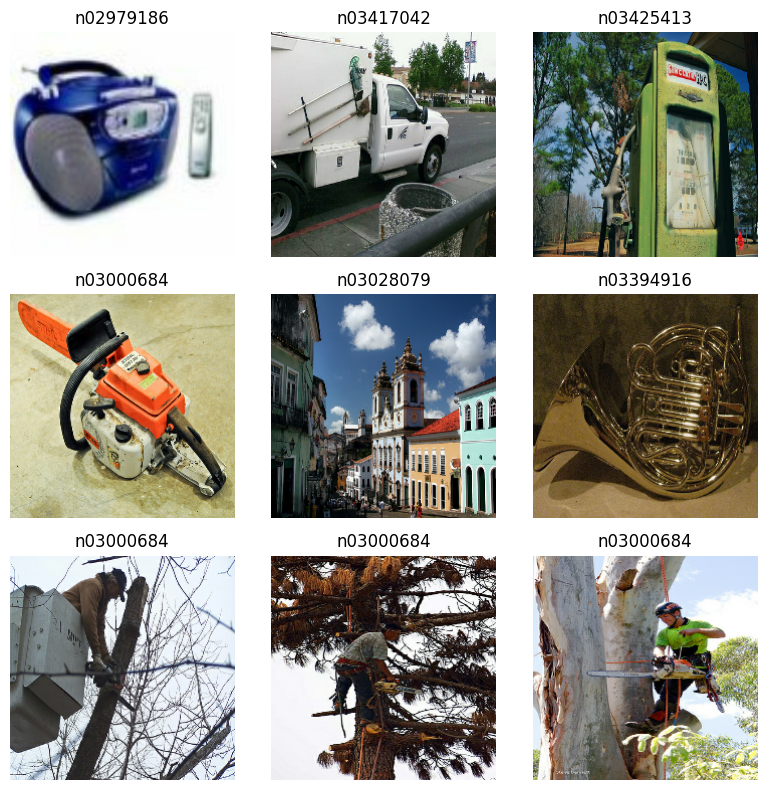

In [ ]:
def show_samples(dataset, class_names, n=9):
    plt.figure(figsize=(8,8))
    for i, (img, lbl) in enumerate(dataset.take(n)):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(img.numpy())
        ax.set_title(class_names[int(lbl)])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Take a small subset to visualize
show_samples(full_dataset, class_names, n=9)


In [ ]:
dataset_size = 946
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

train_ds = full_dataset.take(train_size)
val_ds = full_dataset.skip(train_size)

# Batch and prefetch
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # freeze base layers


num_classes = len(class_names)
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,140,042 (80.64 MB)

 Trainable params: 6,425,354 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
#model compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
#model train
EPOCHS = 5
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)


Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.2213 - loss: 2.3855 - val_accuracy: 0.6113 - val_loss: 1.3509
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.6545 - loss: 1.1621 - val_accuracy: 0.7583 - val_loss: 0.8410
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.8035 - loss: 0.6793 - val_accuracy: 0.7963 - val_loss: 0.7011
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.8796 - loss: 0.4754 - val_accuracy: 0.7965 - val_loss: 0.6448
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9113 - loss: 0.3533 - val_accuracy: 0.7925 - val_loss: 0.6478


In [ ]:
#model Evaluation
val_loss, val_acc = model.evaluate(val_ds)
print(f"\nValidation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

# Predict labels for confusion matrix and classification report
y_true, y_pred = [], []
for images, labels in val_ds:
    preds = np.argmax(model.predict(images, verbose=0), axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)


273/273 ━━━━━━━━━━━━━━━━━━━━ 46s 163ms/step - accuracy: 0.7980 - loss: 0.6438

Validation Loss: 0.6478, Validation Accuracy: 0.7925


In [ ]:
#Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))



Classification Report:
              precision    recall  f1-score   support

   n01440764       0.62      0.95      0.75       875
   n02102040       0.85      0.80      0.83       893
   n02979186       0.83      0.88      0.86       912
   n03000684       0.75      0.47      0.58       782
   n03028079       0.80      0.93      0.86       867
   n03394916       0.92      0.65      0.76       881
   n03417042       0.72      0.88      0.80       880
   n03425413       0.85      0.68      0.75       861
   n03445777       0.82      0.88      0.85       870
   n03888257       0.90      0.77      0.83       892

    accuracy                           0.79      8713
   macro avg       0.81      0.79      0.79      8713
weighted avg       0.81      0.79      0.79      8713



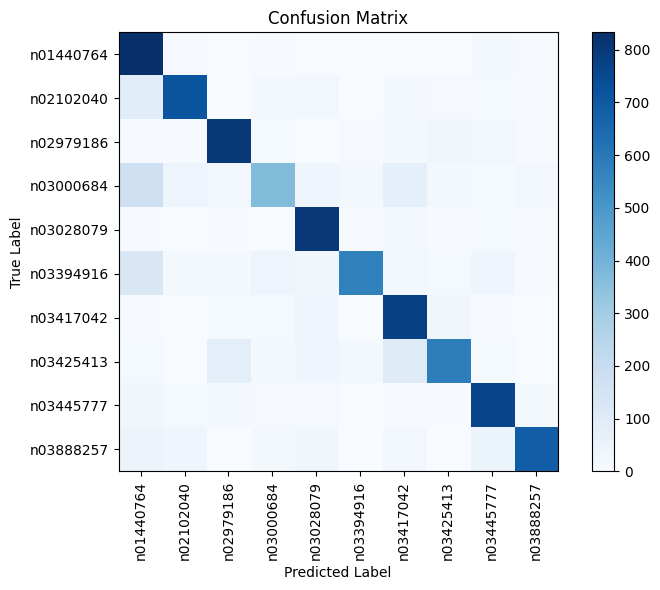

In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(range(num_classes), class_names, rotation=90)
plt.yticks(range(num_classes), class_names)
plt.colorbar()
plt.tight_layout()
plt.show()

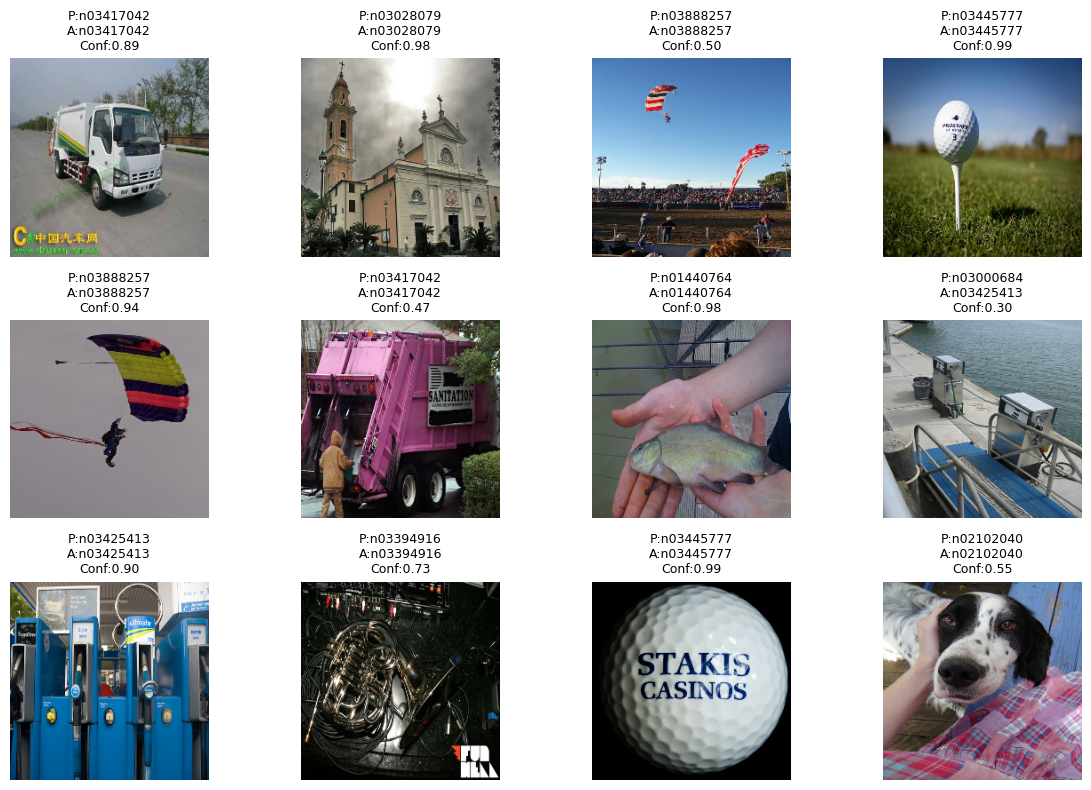

In [ ]:
#some predictions
examples = val_ds.unbatch().take(12)  # take 12 examples
plt.figure(figsize=(12,8))
for i, (img, lbl) in enumerate(examples):
    ax = plt.subplot(3,4,i+1)
    img_input = tf.expand_dims(img, 0)  # model expects batch dimension
    probs = model.predict(img_input, verbose=0)
    pred = np.argmax(probs)
    conf = np.max(probs)
    plt.imshow(img.numpy())
    ax.set_title(f"P:{class_names[pred]}\nA:{class_names[int(lbl)]}\nConf:{conf:.2f}", fontsize=9)
    ax.axis('off')
plt.tight_layout()
plt.show()